In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential,load_model
from tensorflow.keras.layers import Dense,LSTM
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error,r2_score,mean_absolute_error
%matplotlib inline

In [2]:
tf.__version__

'2.10.1'

In [3]:
df = pd.read_csv('./Hostel_Waste_Data.csv')

In [4]:
df.head()

,Prepared,Taken,Waste
0,950,710,240
1,1000,800,200
2,871,702,169
3,997,891,106
4,900,700,200


In [5]:
df.describe()

,Prepared,Taken,Waste
count,1782.000000,1782.000000,1782.000000
mean,911.125701,717.804714,193.320988
std,65.204674,67.829658,42.726376
min,780.000000,607.000000,50.000000
25%,850.000000,667.000000,180.000000
50%,900.000000,702.000000,200.000000
75%,980.000000,750.000000,200.000000
max,1000.000000,891.000000,370.000000


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1782 entries, 0 to 1781
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   Prepared  1782 non-null   int64
 1   Taken     1782 non-null   int64
 2   Waste     1782 non-null   int64
dtypes: int64(3)
memory usage: 41.9 KB


In [7]:
# Define a function to create the dataset for LSTM
def create_dataset(data, time_steps):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:(i + time_steps), :])
        y.append(data[i + time_steps, :])
    return np.array(X), np.array(y)

In [8]:
df['Waste'].shape

(1782,)

In [9]:
dataset = df['Waste'].values.reshape(1782,1)
scaler = MinMaxScaler()
dataset = scaler.fit_transform(dataset)

In [10]:
from joblib import dump,load
dump(scaler, 'minmax_scaler.joblib')
loaded_scaler = load('minmax_scaler.joblib')

In [11]:
# Determine the number of time steps
time_steps = 50  # Or you can set it based on your preference

# Create the dataset with appropriate time steps
X, y = create_dataset(dataset, time_steps)

In [12]:
X.shape, y.shape

((1732, 50, 1), (1732, 1))

In [13]:
train_size = int(len(X) * 0.8)
test_size = len(X) - train_size

In [14]:
X_train, X_test = X[0:train_size], X[train_size:len(X)]
y_train, y_test = y[0:train_size], y[train_size:len(y)]

In [15]:
X_train.shape, X_test.shape

((1385, 50, 1), (347, 50, 1))

In [16]:
y_train.shape, y_test.shape

((1385, 1), (347, 1))

In [17]:
# Define the LSTM model
model = Sequential()
model.add(LSTM(units=50, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(units=25, activation='relu'))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')

In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 50)                10400     
                                                                 
 dense (Dense)               (None, 25)                1275      
                                                                 
 dense_1 (Dense)             (None, 1)                 26        
                                                                 
Total params: 11,701
Trainable params: 11,701
Non-trainable params: 0
_________________________________________________________________


In [19]:
# Train the model
model.fit(X_train, y_train, epochs=100, batch_size=64, verbose=1)

Epoch 1/100
22/22 [==============================] - 4s 63ms/step - loss: 0.0663
Epoch 2/100
22/22 [==============================] - 1s 63ms/step - loss: 0.0190
Epoch 3/100
22/22 [==============================] - 1s 65ms/step - loss: 0.0185
Epoch 4/100
22/22 [==============================] - 1s 67ms/step - loss: 0.0182
Epoch 5/100
22/22 [==============================] - 1s 62ms/step - loss: 0.0184
Epoch 6/100
22/22 [==============================] - 1s 62ms/step - loss: 0.0183
Epoch 7/100
22/22 [==============================] - 1s 64ms/step - loss: 0.0182
Epoch 8/100
22/22 [==============================] - 1s 64ms/step - loss: 0.0182
Epoch 9/100
22/22 [==============================] - 1s 63ms/step - loss: 0.0180
Epoch 10/100
22/22 [==============================] - 1s 64ms/step - loss: 0.0180
Epoch 11/100
22/22 [==============================] - 1s 63ms/step - loss: 0.0180
Epoch 12/100
22/22 [==============================] - 1s 65ms/step - loss: 0.0180
Epoch 13/100
22/22 [=====

In [20]:
# Make predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

11/11 [==============================] - 0s 10ms/step


In [21]:
mean_absolute_error(y_train,train_predict)

0.07855937536442753

In [22]:
mean_absolute_error(y_test,test_predict)

0.08299945388472389

In [23]:
# Invert predictions to original scale
train_predict = scaler.inverse_transform(train_predict)
y_train = scaler.inverse_transform(y_train)
test_predict = scaler.inverse_transform(test_predict)
y_test = scaler.inverse_transform(y_test)

In [24]:
train_predict.shape

(1385, 1)

In [25]:
y_train.shape

(1385, 1)

In [26]:
y_test.shape

(347, 1)

In [27]:
test_predict.shape

(347, 1)

In [28]:
mean_absolute_error(y_train,train_predict)

25.13899997752496

In [29]:
mean_absolute_error(y_test,test_predict)

26.559825666356154

In [30]:
# Calculate root mean squared error
train_score = np.sqrt(mean_squared_error(y_train, train_predict))
test_score = np.sqrt(mean_squared_error(y_test, test_predict))
print('Train RMSE: %.2f' % (train_score))
print('Test RMSE: %.2f' % (test_score))

Train RMSE: 42.19
Test RMSE: 44.30


In [31]:
# model.save('./model.h5')

In [32]:
# model.save('./Models/Model_1/')

In [33]:
X_train[-1].shape

(50, 1)

In [34]:
custom_data_reshaped = np.reshape(X_train[-1], (1, 50, 1))
model.predict(custom_data_reshaped) 

1/1 [==============================] - 0s 38ms/step


array([[0.44207025]], dtype=float32)

In [35]:
custom_data_reshaped[-1][-1][-1]

0.46875

In [36]:
custom_data_reshaped[0][0][0]

0.46875

In [37]:
model.predict(custom_data_reshaped)[0,0]

1/1 [==============================] - 0s 27ms/step


0.44207025

In [38]:
custom_data_reshaped = np.reshape(X_train[-1], (1, 50, 1))
predictions = []

for _ in range(30):
    next_day_prediction = model.predict(custom_data_reshaped)    
    predictions.append(next_day_prediction[0, 0])
    # Update 'custom_data_reshaped' for the next iteration using array slicing
    custom_data_reshaped = np.concatenate((custom_data_reshaped[:, 1:, :], np.reshape(next_day_prediction, (1, 1, 1))), axis=1)

predictions = np.array(predictions)
print(predictions)

1/1 [==============================] - 0s 25ms/step
[0.44207025 0.44245726 0.44367832 0.44528443 0.4469308  0.4484123
 0.44961143 0.45049784 0.4510792  0.45138314 0.45146483 0.45137092
 0.45114914 0.45084578 0.45049974 0.45012277 0.4497746  0.4494547
 0.44914952 0.44887522 0.44863272 0.44841903 0.44825283 0.4480933
 0.44796088 0.44784486 0.4477507  0.44767082 0.44760042 0.44754297]


In [39]:
predictions

array([0.44207025, 0.44245726, 0.44367832, 0.44528443, 0.4469308 ,
       0.4484123 , 0.44961143, 0.45049784, 0.4510792 , 0.45138314,
       0.45146483, 0.45137092, 0.45114914, 0.45084578, 0.45049974,
       0.45012277, 0.4497746 , 0.4494547 , 0.44914952, 0.44887522,
       0.44863272, 0.44841903, 0.44825283, 0.4480933 , 0.44796088,
       0.44784486, 0.4477507 , 0.44767082, 0.44760042, 0.44754297],
      dtype=float32)

In [40]:
predictions = scaler.inverse_transform(predictions.reshape(-1,1))

In [41]:
predictions

array([[191.46248],
       [191.58632],
       [191.97707],
       [192.49101],
       [193.01785],
       [193.49194],
       [193.87566],
       [194.15932],
       [194.34534],
       [194.4426 ],
       [194.46875],
       [194.4387 ],
       [194.3677 ],
       [194.27065],
       [194.15993],
       [194.03929],
       [193.92789],
       [193.8255 ],
       [193.72784],
       [193.64006],
       [193.56247],
       [193.4941 ],
       [193.44089],
       [193.38986],
       [193.34747],
       [193.31036],
       [193.28021],
       [193.25467],
       [193.23213],
       [193.21375]], dtype=float32)

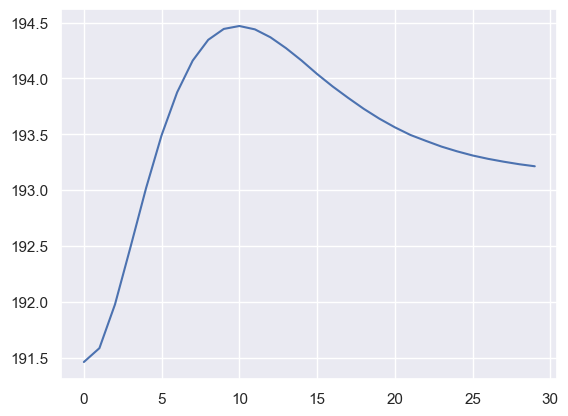

In [42]:
sns.set_theme(style="darkgrid")
plt.plot(predictions)

In [43]:
def predict_next_30_days_api():
    try:
        data = np.array([[0.346875],
       [0.375   ],
       [0.8125  ],
       [0.46875 ],
       [0.40625 ],
       [0.875   ],
       [0.371875],
       [0.46875 ],
       [0.55    ],
       [0.40625 ],
       [0.1875  ],
       [0.46875 ],
       [0.46875 ],
       [0.46875 ],
       [0.209375],
       [0.46875 ],
       [0.365625],
       [0.40625 ],
       [0.40625 ],
       [0.46875 ],
       [0.46875 ],
       [1.      ],
       [0.40625 ],
       [0.40625 ],
       [0.59375 ],
       [0.175   ],
       [0.175   ],
       [0.375   ],
       [0.7125  ],
       [0.46875 ],
       [0.40625 ],
       [0.28125 ],
       [0.375   ],
       [0.40625 ],
       [0.46875 ],
       [0.53125 ],
       [0.46875 ],
       [0.46875 ],
       [0.46875 ],
       [0.40625 ],
       [0.46875 ],
       [0.365625],
       [0.46875 ],
       [0.175   ],
       [0.46875 ],
       [0.175   ],
       [0.28125 ],
       [0.653125],
       [0.40625 ],
       [0.46875 ]])

        # Scale the input data
        scaled_data = scaler.transform(np.array(data).reshape(50, 1))

        # Reshape the data for model prediction
        custom_data_reshaped = np.reshape(scaled_data, (1, 50, 1))

        predictions = []

        # Generate predictions for the next 30 days
        for _ in range(30):
            next_day_prediction = model.predict(custom_data_reshaped)
            predictions.append(next_day_prediction[0, 0])

            # Update 'custom_data_reshaped' for the next iteration
            custom_data_reshaped = np.concatenate(
                (custom_data_reshaped[:, 1:, :], np.reshape(next_day_prediction, (1, 1, 1))),
                axis=1
            )
        predictions = scaler.inverse_transform([predictions])
        return predictions
    except Exception as e:
        error_message = str(e)
        return error_message, 400


In [44]:
predict_next_30_days_api()

1/1 [==============================] - 0s 26ms/step


array([[234.68286514, 228.24537277, 216.83742523, 208.22023392,
        202.00996399, 197.67436981, 194.7426033 , 192.83782959,
        191.65622711, 190.6763649 , 189.92225647, 189.40767288,
        189.12508011, 189.04903412, 189.13808823, 189.34855461,
        189.63970184, 189.97648239, 190.33100128, 190.68256378,
        191.01586342, 191.32116318, 191.59319878, 191.83021545,
        192.03297615, 192.20378876, 192.34600067, 192.46332169,
        192.55954742, 192.63822556]])